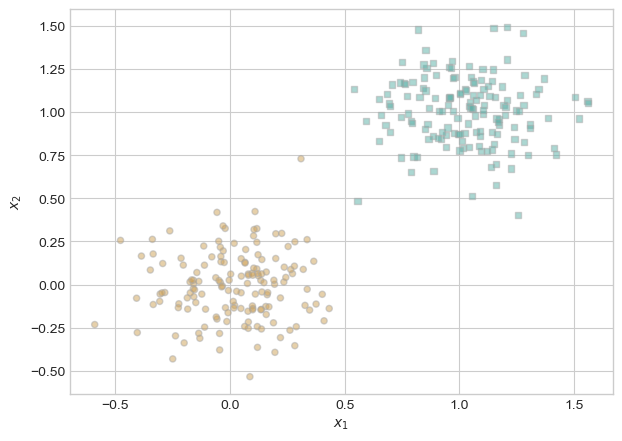

In [198]:
import torch
from matplotlib import pyplot as plt
plt.style.use('seaborn-v0_8-whitegrid')

torch.manual_seed(1234)

def perceptron_data(n_points = 300, noise = 0.2, p_dims = 2):
    
    y = torch.arange(n_points) >= int(n_points/2)
    X = y[:, None] + torch.normal(0.0, noise, size = (n_points,p_dims))
    X = torch.cat((X, torch.ones((X.shape[0], 1))), 1)

    # convert y from {0, 1} to {-1, 1}
    y = 2*y - 1

    return X, y

X, y = perceptron_data(n_points = 300, noise = 0.2)

def plot_perceptron_data(X, y, ax):
    assert X.shape[1] == 3, "This function only works for data created with p_dims == 2"
    targets = [-1, 1]
    markers = ["o" , ","]
    for i in range(2):
        ix = y == targets[i]
        ax.scatter(X[ix,0], X[ix,1], s = 20,  c = y[ix], facecolors = "none", edgecolors = "darkgrey", cmap = "BrBG", vmin = -2, vmax = 2, alpha = 0.5, marker = markers[i])
    ax.set(xlabel = r"$x_1$", ylabel = r"$x_2$")

fig, ax = plt.subplots(1, 1)
X, y = perceptron_data()
plot_perceptron_data(X, y, ax)

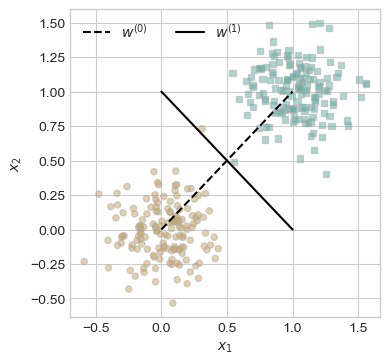

In [199]:
def draw_line(w, x_min, x_max, ax, **kwargs):
    w_ = w.flatten()
    x = torch.linspace(x_min, x_max, 101)
    y = -(w_[0]*x + w_[2])/w_[1]
    l = ax.plot(x, y, **kwargs)

fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)

w_0 = torch.Tensor([1, -1, 0])
w_1 = torch.Tensor([1,  1, -1]) 

draw_line(w_0, 0, 1, ax, color = "black", linestyle = "dashed", label = r"$w^{(0)}$")
draw_line(w_1, 0, 1, ax, color = "black", label = r"$w^{(1)}$")

l = ax.legend(ncol = 2)

In [307]:
import torch

class LinearModel:

    def __init__(self):
        self.w = None 

    def score(self, X):
        """
        Compute the scores for each data point in the feature matrix X. 
        The formula for the ith entry of s is s[i] = <self.w, x[i]>. 

        If self.w currently has value None, then it is necessary to first initialize self.w to a random value. 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

        RETURNS: 
            s torch.Tensor: vector of scores. s.size() = (n,)
        """
        if self.w is None: 
            self.w = torch.rand((X.size()[1]))

        # your computation here: compute the vector of scores s
        return X@self.w

    def predict(self, X):
        """
        Compute the predictions for each data point in the feature matrix X. The prediction for the ith data point is either 0 or 1. 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

        RETURNS: 
            y_hat, torch.Tensor: vector predictions in {0.0, 1.0}. y_hat.size() = (n,)
        """
        return self.score(X) > 0.5

class Perceptron(LinearModel):

    def loss(self, X, y):
        """
        Compute the misclassification rate. A point i is classified correctly if it holds that s_i*y_i_ > 0, where y_i_ is the *modified label* that has values in {-1, 1} (rather than {0, 1}). 

        ARGUMENTS: 
            X, torch.Tensor: the feature matrix. X.size() == (n, p), 
            where n is the number of data points and p is the 
            number of features. This implementation always assumes 
            that the final column of X is a constant column of 1s. 

            y, torch.Tensor: the target vector.  y.size() = (n,). The possible labels for y are {0, 1}
        
        HINT: In order to use the math formulas in the lecture, you are going to need to construct a modified set of targets and predictions that have entries in {-1, 1} -- otherwise none of the formulas will work right! An easy to to make this conversion is: 
        
        y_ = 2*y - 1
        """
    
        # replace with your implementation
        s = (self.score(X))*y < 0
        return (1.0*s).mean()

    def grad(self, X, y):
        score = X@self.w
        s = (score)*y < 0
        return (X*(1.0*(s*y)[0]))

class PerceptronOptimizer:

    def __init__(self, model):
        self.model = model 
    
    def step(self, X, y):
        """
        Compute one step of the perceptron update using the feature matrix X 
        and target vector y. 
        """
        i = torch.randint(X.size()[0], size = (1,))
        new_w = self.model.w + self.model.grad(X[[i],:],y[i])
        self.model.w = new_w[0]

In [264]:
torch.tensor([12,2,3]) + torch.tensor([[2,3,2]])

tensor([[14,  5,  5]])

tensor(False)


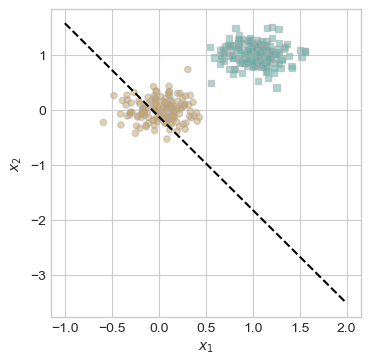

In [266]:
p = Perceptron()
s = p.score(X)
l = p.loss(X, y)
print(l == 0.5)
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")

In [304]:
# instantiate a model and an optimizer
p = Perceptron() 
opt = PerceptronOptimizer(p)

loss = 1.0
count = 0
# for keeping track of loss values
loss_vec = []

n = X.size()[0]

while loss > 0: # dangerous -- only terminates if data is linearly separable
    count += 1
    # not part of the update: just for tracking our progress    
    loss = p.loss(X, y) 
    #print(loss, "3")
    loss_vec.append(loss)
    
    # pick a random data point
    i = torch.randint(n, size = (1,))
    x_i = X[[i],:]
    y_i = y[i]
    
    # perform a perceptron update using the random data point
    opt.step(X, y)

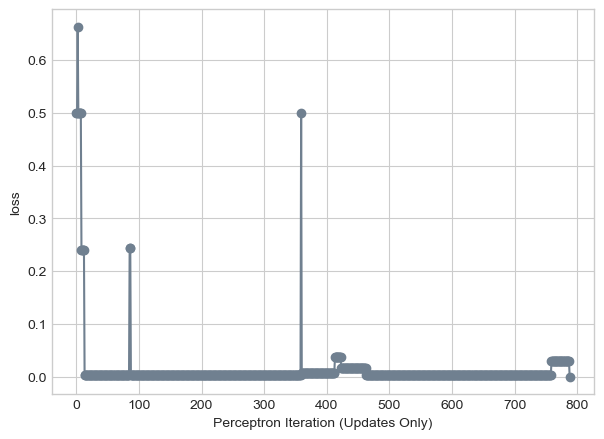

In [305]:
from matplotlib import pyplot as plt

plt.plot(loss_vec, color = "slategrey")
plt.scatter(torch.arange(len(loss_vec)), loss_vec, color = "slategrey")
labs = plt.gca().set(xlabel = "Perceptron Iteration (Updates Only)", ylabel = "loss")

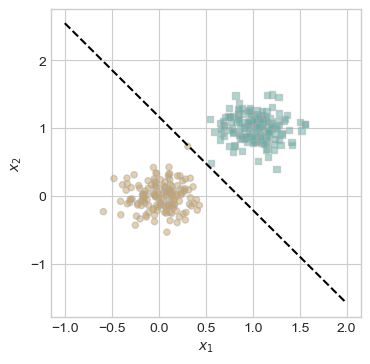

In [306]:
fig, ax = plt.subplots(1, 1, figsize = (4, 4))
plot_perceptron_data(X, y, ax)
draw_line(p.w, x_min = -1, x_max = 2, ax = ax, color = "black", linestyle = "dashed")